In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
import random
import time
import math

from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
from torch.optim import Adam, SGD

# !pip install torchmetrics
# import torchmetrics

!pip install torchinfo
from torchinfo import summary

In [2]:
#For ensuaring the reproducible results
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
image_size = 512
batch_size = 16

In [4]:
df_train = pd.read_csv('../input/fgvc-aircraft/train.csv')
df_val = pd.read_csv('../input/fgvc-aircraft/val.csv')
df_test = pd.read_csv('../input/fgvc-aircraft/test.csv')
df_train.head()

filename  Classes  Labels
0  1025794.jpg  707-320       0
1  1340192.jpg  707-320       0
2  0056978.jpg  707-320       0
3  0698580.jpg  707-320       0
4  0450014.jpg  707-320       0

In [5]:
tpath = "../input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images"
df_train = df_train.assign(Paths = tpath + "/" + df_train["filename"])
df_val = df_val.assign(Paths = tpath + "/" + df_val["filename"])
df_test = df_test.assign(Paths = tpath + "/" + df_test["filename"])

def get_data(df):
    data = []
    for idx in range(len(df)):
        data.append((str(df.at[idx,"Paths"]),df.at[idx,"Labels"]))
    return data

data_train = get_data(df_train)
data_val = get_data(df_val)
data_test = get_data(df_test)
print(data_train[10])
print(data_train[100])
print(len(data_train))
print(len(data_val))
print(len(data_test))


('../input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/0951982.jpg', 0)
('../input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/1899111.jpg', 3)
3334
3333
3333


In [6]:
# #Get the infos about the size of the data
# for x, y in data_train:
#     example_image = cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)
#     print(example_image.shape)

##The quality of most of the pictures are quite good (approximately around (512, 1024,3)). So we're going to convert the pic to 512x512x3

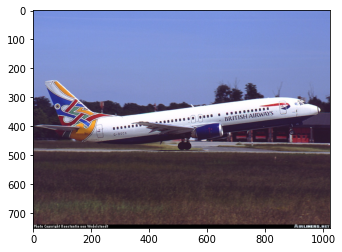

In [7]:
#We notice that there'are 20-pixels high authorship informations (according to the dataset's informations)
example_image = cv2.cvtColor(cv2.imread(data_train[150][0]), cv2.COLOR_BGR2RGB)
plt.imshow(example_image)

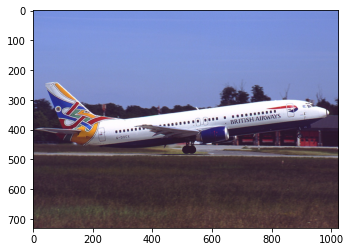

In [8]:
#Crop the banner (authorship information) (20 pixels high at the bottom)
example_image = cv2.cvtColor(cv2.imread(data_train[150][0]), cv2.COLOR_BGR2RGB)
example_image
plt.imshow(example_image[0:-20, :])

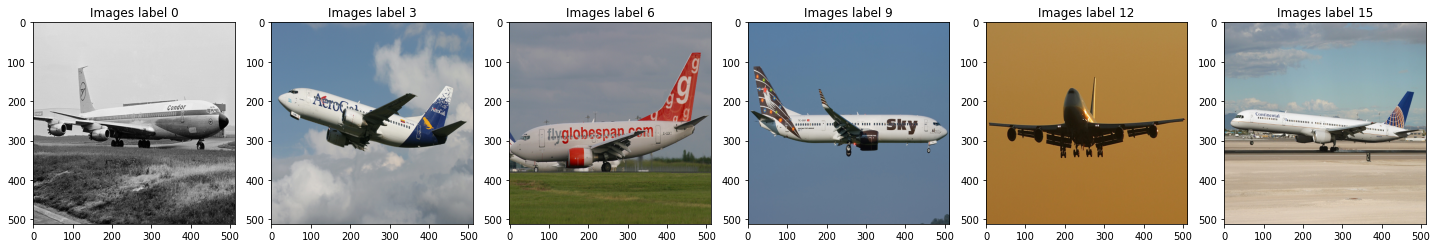

In [9]:
#Vision about the data
num_images = 6
figures,axis = plt.subplots(1,num_images,figsize=(20,20))

for idx in range(num_images):
  example_image = cv2.cvtColor(cv2.imread(data_train[100*idx][0]), cv2.COLOR_BGR2RGB)

    #Remove the banner (authorship information)
  example_image = example_image[0:-20,:]

  example_image = cv2.resize(example_image, (image_size,image_size),interpolation=cv2.INTER_CUBIC)

  axis[idx].set_title("Images label " + str(data_train[100*idx][1]))
  axis[idx].imshow(example_image)


#OpenCV uses BGR while mathplotlib uses RGB
plt.tight_layout()
plt.show()

In [10]:
class LoadDataset(Dataset):
    def __init__(self, data, transform, image_size):
        self.data = data
        self.len = len(self.data)
        self.transform = transform
        self.size = image_size

        
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        image_path, label = self.data[idx]

        img = np.array(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
        
        #Crop the banner (20-pixels high)
        img = img[0:-20,:]
        
        resized_img = cv2.resize(img, (self.size,self.size),interpolation =cv2.INTER_CUBIC).astype("float32")/255
        
        #From BGR (default in OpenCV), return the RGB image
        image_tensor = torch.from_numpy(np.transpose(resized_img,(2,0,1)))
        
        #Return the transformed images and the label
        
        return self.transform(image_tensor), label

In [11]:
#Transform
transformed = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   #From ImageNet  
                    ])

#Device

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
train_set = LoadDataset(data=data_train, transform=transformed, image_size=image_size)
val_set = LoadDataset(data=data_val, transform=transformed, image_size=image_size)
test_set = LoadDataset(data=data_test, transform=transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]), image_size=image_size)

In [13]:
# for x,y in train_set:
#     print(x,y)
#     break
# for x,y in val_set:
#     print(x,y)
#     break

In [14]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size = batch_size, shuffle = True, num_workers =2
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size = batch_size, shuffle = True, num_workers =2
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size = batch_size, shuffle = True
)

In [15]:
class Dense_Block(nn.Module):
    def __init__(self, in_channels):
        super(Dense_Block, self).__init__()

        self.relu = nn.ReLU(inplace = True)
        self.bn = nn.BatchNorm2d(num_features = in_channels)

        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.maxpool = nn.MaxPool2d(2)
        

 
    def forward(self, x):
 
        bn = self.bn(x)
        conv1 = self.relu(self.conv1(bn))

        conv2 = self.relu(self.conv2(conv1))
        c2_dense = self.relu(torch.cat([conv1, conv2], 1))

        conv3 = self.relu(self.conv3(c2_dense))
        c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))
        
        conv4 = self.relu(self.conv4(c3_dense))
        c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1))
        
#         conv5 = self.relu(self.conv5(c4_dense))
#         c5_dense = torch.cat([conv1, conv2, conv3, conv4, conv5], 1)

        return self.maxpool(c4_dense)
 
class Transition_Layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition_Layer, self).__init__()

        self.relu = nn.ReLU(inplace = True)
        self.bn = nn.BatchNorm2d(num_features = out_channels)
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, bias = False)
        self.avg_pool = nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0)

    def forward(self, x):
 
        bn = self.bn(self.relu(self.conv(x)))
        out = self.avg_pool(bn)
 
        return out
 
class DenseNet(nn.Module):
    def __init__(self, nr_classes):
        super(DenseNet, self).__init__()
 
        self.lowconv = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 7, padding = 3, bias = False)
        self.relu = nn.ReLU()
 
           # Make Dense Blocks
        self.denseblock1 = self._make_dense_block(Dense_Block, 64)
        self.denseblock2 = self._make_dense_block(Dense_Block, 64)
        self.denseblock3 = self._make_dense_block(Dense_Block, 64)

           # Make transition Layers
        self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 128, out_channels = 64)
        self.transitionLayer2 = self._make_transition_layer(Transition_Layer, in_channels = 128, out_channels = 64)
        self.transitionLayer3 = self._make_transition_layer(Transition_Layer, in_channels = 128, out_channels = 128)

           # Classifier
        self.bn = nn.BatchNorm2d(128)
        
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(128*8*8,1024),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(1024,512),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(512,nr_classes)
            
        )
 
    def _make_dense_block(self, block, in_channels):
        layers = []
        layers.append(block(in_channels))
        return nn.Sequential(*layers)
 
    def _make_transition_layer(self, layer, in_channels, out_channels):
        modules = []
        modules.append(layer(in_channels, out_channels))
        return nn.Sequential(*modules)
 
    def forward(self, x):
        out = self.relu(self.lowconv(x))

        out = self.denseblock1(out)
        out = self.transitionLayer1(out)

        out = self.denseblock2(out)
        out = self.transitionLayer2(out)

        out = self.denseblock3(out)
        out = self.transitionLayer3(out)

        out = self.bn(out)
        
        out = self.flatten(out)

        out = self.classifier(out)
 
        return out

In [16]:
from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



model = DenseNet(100).to(device)

summary(model, input_size=(16, 3, 512, 512))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [16, 100]                 --
├─Conv2d: 1-1                            [16, 64, 512, 512]        9,408
├─ReLU: 1-2                              [16, 64, 512, 512]        --
├─Sequential: 1-3                        [16, 128, 256, 256]       --
│    └─Dense_Block: 2-1                  [16, 128, 256, 256]       36,896
│    │    └─BatchNorm2d: 3-1             [16, 64, 512, 512]        128
│    │    └─Conv2d: 3-2                  [16, 32, 512, 512]        18,464
│    │    └─ReLU: 3-3                    [16, 32, 512, 512]        --
│    │    └─Conv2d: 3-4                  [16, 32, 512, 512]        9,248
│    │    └─ReLU: 3-5                    [16, 32, 512, 512]        --
│    │    └─ReLU: 3-6                    [16, 64, 512, 512]        --
│    │    └─Conv2d: 3-7                  [16, 32, 512, 512]        18,464
│    │    └─ReLU: 3-8                    [16, 32, 512, 512]       

In [17]:
def train_epoch(net, dataloader, lr = 0.01, optimizer=None, loss_fn = nn.NLLLoss()):
  optimizer = optimizer or torch.optim.Adam(net.parameters(), lr = lr)
  net.train()
  total_loss, acc, count = 0,0,0
  for features, labels in dataloader:
    optimizer.zero_grad()
    lbls = labels.to(device)
    out = net(features.to(device))
    loss = loss_fn(out, lbls) #cross_entropy(out, labels)
    loss.backward()
    optimizer.step()
    total_loss +=loss
    _, predicted = torch.max(out,1)
    acc +=(predicted == lbls).sum()
    count += len(labels)
  
  return total_loss.item()/count, acc.item()/count

def validate(net, dataloader, loss_fn = nn.NLLLoss()):
  net.eval()
  count, acc, loss = 0,0,0
  with torch.no_grad():
    for features, labels in dataloader:
      lbls = labels.to(device)
      out = net(features.to(device))
      loss += loss_fn(out,lbls)
      pred = torch.max(out,1)[1]
      acc += (pred==lbls).sum()
      count += len(labels)

  return loss.item()/count, acc.item()/count

def train(net, train_loader, val_loader, optimizer = None, lr = 0.001, epochs = 10, loss_fn = nn.NLLLoss()):
  optimizer = optimizer or torch.optim.Adam(net.parameters(), lr = lr)
  best_accuracy=0.0
  res = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
  for ep in range(epochs):
    since = time.time()
    
    
    tl,ta = train_epoch(net,train_loader, optimizer = optimizer, lr=lr, loss_fn = loss_fn)
    vl, va = validate(net, val_loader, loss_fn = loss_fn)
    print(f"Epoch {ep}, Train acc = {ta:.3f}, Val acc = {va:.3f}, Train loss = {tl:.3f}, Val loss = {vl:.3f}")
    res["train_loss"].append(tl)
    res["train_acc"].append(ta)
    res["val_loss"].append(vl)
    res["val_acc"].append(va)
    if va>best_accuracy:
        torch.save(net,"/kaggle/working/BestModel.pt")
        best_accuracy=va
        
        
    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  return res
def plot_results(hist):
  plt.figure(figsize = (15,15))
  plt.subplot(1,2,1)
  plt.plot(hist["train_acc"], label = "Training acc")
  plt.plot(hist["val_acc"], label = "Validation acc")
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(hist["train_loss"], label = "Training loss")
  plt.plot(hist["val_loss"], label = "Validation loss")
  plt.legend()

Epoch 0, Train acc = 0.018, Val acc = 0.018, Train loss = 0.294, Val loss = 0.292
5m 42s
Epoch 1, Train acc = 0.023, Val acc = 0.019, Train loss = 0.286, Val loss = 0.289
5m 35s
Epoch 2, Train acc = 0.032, Val acc = 0.032, Train loss = 0.282, Val loss = 0.282
5m 33s
Epoch 3, Train acc = 0.030, Val acc = 0.026, Train loss = 0.278, Val loss = 0.282
5m 32s
Epoch 4, Train acc = 0.037, Val acc = 0.027, Train loss = 0.278, Val loss = 0.284
5m 33s
Epoch 5, Train acc = 0.039, Val acc = 0.027, Train loss = 0.273, Val loss = 0.287
5m 34s
Epoch 6, Train acc = 0.054, Val acc = 0.025, Train loss = 0.267, Val loss = 0.286
5m 35s
Epoch 7, Train acc = 0.070, Val acc = 0.049, Train loss = 0.258, Val loss = 0.264
5m 36s
Epoch 8, Train acc = 0.083, Val acc = 0.032, Train loss = 0.244, Val loss = 0.285
5m 34s
Epoch 9, Train acc = 0.124, Val acc = 0.096, Train loss = 0.227, Val loss = 0.247
5m 36s
Epoch 10, Train acc = 0.136, Val acc = 0.068, Train loss = 0.218, Val loss = 0.308
5m 32s
Epoch 11, Train acc 

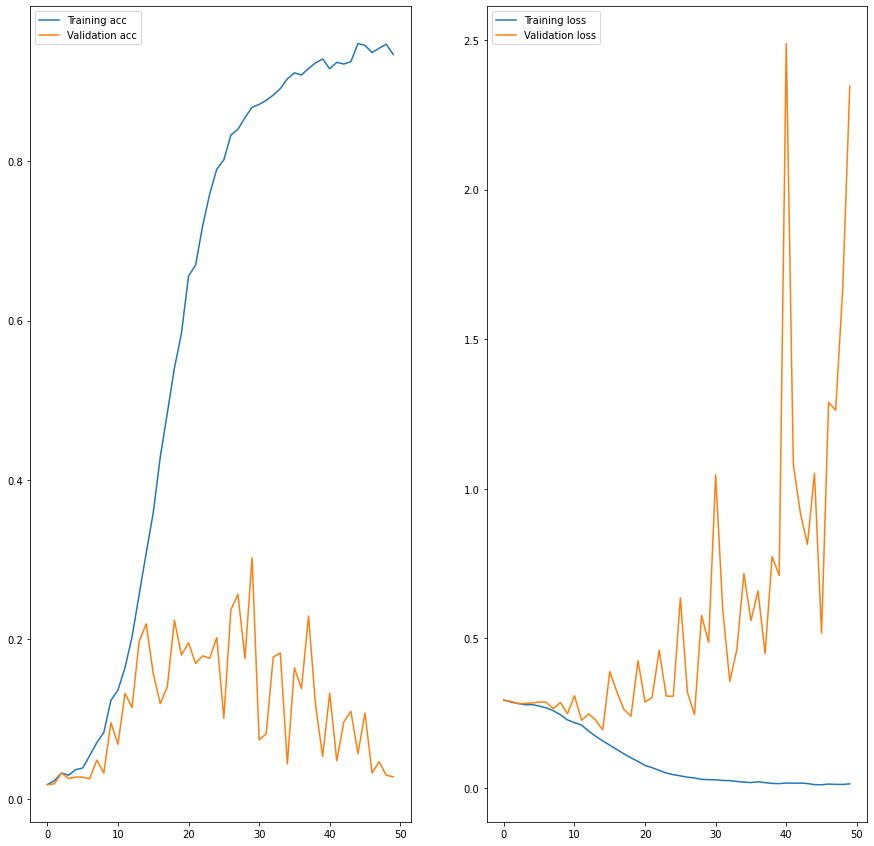

In [18]:
hist = train(model,train_loader,val_loader,optimizer = Adam(model.parameters(),lr=0.001), epochs=50, loss_fn = nn.CrossEntropyLoss())
plot_results(hist)

In [19]:
model = torch.load("./BestModel.pt")

In [20]:
loss_test, acc_test =  validate(model, test_loader, loss_fn = nn.CrossEntropyLoss())

In [21]:
print(f"Loss on test set is {loss_test}, accuracy on test set {acc_test*100}  %")

Loss on test set is 0.41027593970334536, accuracy on test set 6.5706570657065715  %


In [22]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sn
# import pandas as pd

# y_pred = []
# y_true = []

# # iterate over test data
# for inputs, labels in test_loader:
#     labels = labels.to(device)
#     output = model(inputs.to(device)) # Feed Network

#     output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
#     y_pred.extend(output) # Save Prediction

#     labels = labels.data.cpu().numpy()
#     y_true.extend(labels) # Save Truth

# # constant for classes
# classes = [i for i in range(0,100)]

# # Build confusion matrix
# cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (12,7))
# sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')